In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import time
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
class LUT:
    def __init__(self, inputs, indexes_0, indexes_1, k , index = []):
        # build lut
        self.k = k
        if (index == []):
            self.index = np.sort(np.random.choice(len(inputs[0]),k,replace = False))
        else:
            self.index = index
        self.inv = np.arange(k-1,-1,-1)
        self.output = np.zeros((2**k), int)
        self.count_0 = np.zeros((2**k), int)
        self.count_1 = np.zeros((2**k), int)
        self.count(inputs[:,self.index], indexes_0,indexes_1)
        
    def count(self, subset, indexes_0, indexes_1):
        zeros = Counter(np.sort(self.get_index_vec_to_dec(subset[indexes_0])))
        ones =  Counter(np.sort(self.get_index_vec_to_dec(subset[indexes_1])))
        for key in zeros.keys():
            self.count_0[key] = zeros[key]
        for key in ones.keys():
            self.count_1[key] = ones[key]
        # compute lut
        self.output[self.count_0 > self.count_1] = 0
        self.output[self.count_0 < self.count_1] = 1
        # picked uniformly at random
        self.output[self.count_0 == self.count_1] = np.random.choice([0,1], len(self.output[self.count_0 == self.count_1]))
        
    def get_index_vec_to_dec(self, X , axis = 1):
        dec_index = np.sum(X * np.power(2*np.ones(self.k,int),self.inv),axis= axis)
        return dec_index
    
    def get_index_dec_to_vec(self, dec):
        return "{0:b}".format(dec).zfill(self.k)
    
    def look(self, X):
        # X is a numpy array
        X = np.array(X)
        return self.output[self.get_index_vec_to_dec(X[self.index], 0)]
    
    def look_array(self, dataset):
        subdataset = dataset[:,self.index]
        return self.output[self.get_index_vec_to_dec(subdataset)]
        
    def score(self, labels, dataset):
        predicted = self.look_array(dataset)
        return accuracy_score(labels,predicted)
    
    def show(self):
        print("Look up table")
        print("Index = {}".format(self.index))
        print("  p    |  y0 |  y1 |  f   |")
        for i in range(len(self.output)):
            if (self.count_0[i] == self.count_1[i]):
                f = "{}*".format(self.output[i])
            else:
                f = "{} ".format(self.output[i])
            print("  {}   |  {}  |  {}  |  {}  |".format(self.get_index_dec_to_vec(i), self.count_0[i], self.count_1[i], f))
            
    def clean(self):
        self.count_0 = None
        self.count_1 = None

In [3]:
class NLUTS :
    def __init__(self,k,n_luts = [1024,512,512,256,16,1], n_layer = 6):
        self.layers = []
        self.k = k
        self.n_layer = n_layer
        self.n_luts = n_luts
    
    def train(self,X_train,y_train, indexes_0, indexes_1):

        inputs = X_train
        outputs = inputs
        # hidden layers + 1 output layer
        for l in range(self.n_layer):
            layer = []
            inputs = outputs
            outputs = np.zeros((len(X_train),self.n_luts[l]),int)
            for i in range(n_luts[l]):
                lut = LUT(inputs, indexes_0, indexes_1, self.k)
                outputs[:,i] = lut.look_array(inputs)
                layer.append(lut)
            self.layers.append(layer)
        return outputs
    
    def predict(self,X,y):
        inputs = X
        outputs = inputs
        for layer in self.layers:
            inputs = outputs
            outputs = np.zeros((len(X),len(layer)),int)
            for i in range(len(layer)):
                outputs[:,i] = layer[i].look_array(inputs)
        return outputs
    
    def score(self,X,y):
        return accuracy_score(y, self.predict(X,y))

In [4]:
with open('./data/mnist/mnist_X_train.p', 'rb') as f:
    X_train = pickle.load(f)
with open('./data/mnist/binarized_mnist_y_train.p', 'rb') as f:
    y_train = pickle.load(f)
with open('./data/mnist/mnist_X_test.p', 'rb') as f:
    X_test = pickle.load(f)
with open('./data/mnist/binarized_mnist_y_test.p', 'rb') as f:
    y_test = pickle.load(f)

## Test varying the number of luts

In [4]:
n_luts = [784,64,64,64,64,8,1] # number of luts per layer
k = 8 # sampling input
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


100%|████████████████████████████████████████████████████████████████████████████████| 784/784 [00:12<00:00, 61.61it/s]


layer 1 nb luts : 64


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:05<00:00, 13.24it/s]


layer 2 nb luts : 64


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:05<00:00, 10.45it/s]


layer 3 nb luts : 64


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:05<00:00, 11.76it/s]


layer 4 nb luts : 64


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 13.54it/s]


layer 5 nb luts : 8


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.12it/s]


layer 6 nb luts : 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.79it/s]


Time spent : 34.74s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,64.000000,64.000000,64.000000,64.000000,8.000000,1.00000
mean,0.507220,0.615896,0.752570,0.823302,0.849653,0.862085,0.86985
std,0.036831,0.044488,0.021528,0.006580,0.002479,0.000937,NaN
min,0.402167,0.517467,0.695167,0.805350,0.842200,0.860633,0.86985
25%,0.495071,0.582087,0.736204,0.819758,0.848258,0.861617,0.86985
50%,0.509933,0.607817,0.755658,0.823675,0.849992,0.861950,0.86985
75%,0.513792,0.640533,0.769258,0.827817,0.851162,0.862625,0.86985
max,0.668500,0.714183,0.787350,0.836833,0.854683,0.863417,0.86985


In [5]:
# Compute test accuracy

# input layer
k = 8

test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.51it/s]


Time spent : 3.86s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,64.000000,64.000000,64.000000,64.000000,8.000000,1.0000
mean,0.511235,0.621620,0.758478,0.825833,0.847450,0.854600,0.8549
std,0.038818,0.049406,0.024504,0.007608,0.003467,0.001752,NaN
min,0.391300,0.519100,0.690900,0.801700,0.838000,0.851400,0.8549
25%,0.497475,0.586900,0.740325,0.822025,0.845000,0.853650,0.8549
50%,0.513900,0.614500,0.759900,0.826100,0.847800,0.855050,0.8549
75%,0.517125,0.658200,0.777125,0.831800,0.849500,0.856050,0.8549
max,0.684600,0.725900,0.799300,0.839500,0.857300,0.856300,0.8549


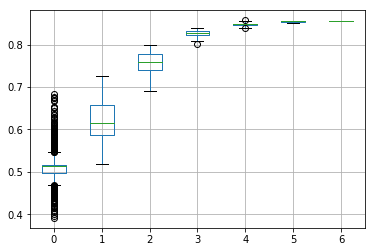

In [6]:
df.boxplot()

In [ ]:
n_luts = [784,64,64,64,64,8,1] # number of luts per layer
k = 8 # sampling input
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

In [ ]:
# Compute test accuracy

# input layer
k = 8

test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

In [25]:
n_luts = [1024,512,512,256,16,1] # number of luts per layer
k_list = [2,4,6,8,10,12,14,16] # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for k in k_list:
    interm = time.time()
    
    nn = NLUTS(k,n_luts)
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 2 training accuracy : 0.702
k = 2 test accuracy : 0.715
Time spent :193.80s
k = 4 training accuracy : 0.816
k = 4 test accuracy : 0.819
Time spent :217.41s
k = 6 training accuracy : 0.856
k = 6 test accuracy : 0.854
Time spent :255.88s
k = 8 training accuracy : 0.904
k = 8 test accuracy : 0.882
Time spent :295.56s
k = 10 training accuracy : 0.957
k = 10 test accuracy : 0.902
Time spent :338.51s
k = 12 training accuracy : 0.990
k = 12 test accuracy : 0.902
Time spent :387.90s
k = 14 training accuracy : 0.999
k = 14 test accuracy : 0.822
Time spent :437.24s
k = 16 training accuracy : 1.000
k = 16 test accuracy : 0.659
Time spent :505.93s
Total Time spent : 2633.20s


In [26]:
n_luts = [512,256,256,64,16,1] # number of luts per layer
k_list = [2,4,6,8,10,12,14,16] # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for k in k_list:
    interm = time.time()
    
    nn = NLUTS(k,n_luts)
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 2 training accuracy : 0.706
k = 2 test accuracy : 0.719
Time spent :100.00s
k = 4 training accuracy : 0.818
k = 4 test accuracy : 0.827
Time spent :115.21s
k = 6 training accuracy : 0.866
k = 6 test accuracy : 0.862
Time spent :138.67s
k = 8 training accuracy : 0.905
k = 8 test accuracy : 0.884
Time spent :154.91s
k = 10 training accuracy : 0.953
k = 10 test accuracy : 0.899
Time spent :183.67s
k = 12 training accuracy : 0.991
k = 12 test accuracy : 0.905
Time spent :207.19s
k = 14 training accuracy : 0.999
k = 14 test accuracy : 0.822
Time spent :229.79s
k = 16 training accuracy : 1.000
k = 16 test accuracy : 0.678
Time spent :262.78s
Total Time spent : 1392.30s


In [32]:
n_luts = [512,64,16,16,16,1] # number of luts per layer
k_list = [2,4,6,8,10,12,14,16] # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for k in k_list:
    interm = time.time()
    
    nn = NLUTS(k,n_luts)
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 2 training accuracy : 0.656
k = 2 test accuracy : 0.653
Time spent :25.99s
k = 4 training accuracy : 0.789
k = 4 test accuracy : 0.795
Time spent :31.18s
k = 6 training accuracy : 0.844
k = 6 test accuracy : 0.842
Time spent :41.48s
k = 8 training accuracy : 0.890
k = 8 test accuracy : 0.876
Time spent :43.06s
k = 10 training accuracy : 0.935
k = 10 test accuracy : 0.887
Time spent :53.76s
k = 12 training accuracy : 0.978
k = 12 test accuracy : 0.893
Time spent :64.56s
k = 14 training accuracy : 0.997
k = 14 test accuracy : 0.876
Time spent :74.37s
k = 16 training accuracy : 1.000
k = 16 test accuracy : 0.782
Time spent :86.89s
Total Time spent : 421.32s


In [40]:
n_luts_list =[[32]*2**i+[1] for i in range(6)]  # number of luts per layer
n_layers = [2**i+1 for i in range(6)]
k = 12 # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for n in range(len(n_luts_list)):
    interm = time.time()
    n_luts = n_luts_list[n]
    nn = NLUTS(k,n_luts, n_layers[n])
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 12 training accuracy : 0.855
k = 12 test accuracy : 0.836
Time spent :4.75s
k = 12 training accuracy : 0.912
k = 12 test accuracy : 0.857
Time spent :8.59s
k = 12 training accuracy : 0.959
k = 12 test accuracy : 0.861
Time spent :15.38s
k = 12 training accuracy : 0.960
k = 12 test accuracy : 0.859
Time spent :28.78s
k = 12 training accuracy : 0.961
k = 12 test accuracy : 0.856
Time spent :62.48s
k = 12 training accuracy : 0.964
k = 12 test accuracy : 0.865
Time spent :125.70s
Total Time spent : 245.70s


In [41]:
n_luts_list =[[64]*2**i+[1] for i in range(6)]  # number of luts per layer
n_layers = [2**i+1 for i in range(6)]
k = 12 # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for n in range(len(n_luts_list)):
    interm = time.time()
    n_luts = n_luts_list[n]
    nn = NLUTS(k,n_luts, n_layers[n])
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 12 training accuracy : 0.851
k = 12 test accuracy : 0.816
Time spent :8.59s
k = 12 training accuracy : 0.925
k = 12 test accuracy : 0.873
Time spent :16.66s
k = 12 training accuracy : 0.969
k = 12 test accuracy : 0.881
Time spent :35.32s
k = 12 training accuracy : 0.978
k = 12 test accuracy : 0.875
Time spent :68.90s
k = 12 training accuracy : 0.979
k = 12 test accuracy : 0.871
Time spent :123.38s
k = 12 training accuracy : 0.980
k = 12 test accuracy : 0.880
Time spent :237.10s
Total Time spent : 489.98s


In [42]:
n_luts_list =[[128]*2**i+[1] for i in range(6)]  # number of luts per layer
n_layers = [2**i+1 for i in range(6)]
k = 12 # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for n in range(len(n_luts_list)):
    interm = time.time()
    n_luts = n_luts_list[n]
    nn = NLUTS(k,n_luts, n_layers[n])
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 12 training accuracy : 0.840
k = 12 test accuracy : 0.817
Time spent :18.46s
k = 12 training accuracy : 0.940
k = 12 test accuracy : 0.893
Time spent :31.76s
k = 12 training accuracy : 0.980
k = 12 test accuracy : 0.898
Time spent :62.44s
k = 12 training accuracy : 0.989
k = 12 test accuracy : 0.892
Time spent :121.85s
k = 12 training accuracy : 0.989
k = 12 test accuracy : 0.883
Time spent :244.77s
k = 12 training accuracy : 0.990
k = 12 test accuracy : 0.887
Time spent :506.47s
Total Time spent : 985.77s


## Test varying luts #2

k = 8

Numbers tested : 64, 128, 256, 512, 1024, 2048, 4096

### 64 luts

In [29]:
n_luts = [784] + [64]*5 + [1] # number of luts per layer
k = 8 # sampling input
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 64


layer 2 nb luts : 64


layer 3 nb luts : 64


layer 4 nb luts : 64


layer 5 nb luts : 64


layer 6 nb luts : 1


Time spent : 16.31s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,64.000000,64.000000,64.000000,64.000000,64.000000,1.000000
mean,0.507220,0.608946,0.757488,0.840729,0.869782,0.881573,0.888167
std,0.036831,0.041860,0.020859,0.006927,0.002394,0.000740,NaN
min,0.402167,0.527933,0.704517,0.817383,0.863517,0.879100,0.888167
25%,0.495071,0.582688,0.745000,0.837371,0.868400,0.881112,0.888167
50%,0.509933,0.602292,0.760125,0.840675,0.869700,0.881675,0.888167
75%,0.513792,0.641033,0.772500,0.845213,0.871125,0.882004,0.888167
max,0.668500,0.710200,0.806783,0.852900,0.875467,0.883150,0.888167


In [30]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 1.69s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,64.000000,64.000000,64.000000,64.000000,64.000000,1.0000
mean,0.511235,0.610395,0.758317,0.840036,0.865062,0.871670,0.8756
std,0.038818,0.045694,0.024657,0.008163,0.003118,0.001559,NaN
min,0.391300,0.534100,0.694100,0.811800,0.858300,0.868600,0.8756
25%,0.497475,0.578900,0.742575,0.835125,0.862600,0.870500,0.8756
50%,0.513900,0.602250,0.762600,0.840550,0.865350,0.871450,0.8756
75%,0.517125,0.649425,0.776775,0.845700,0.866825,0.873025,0.8756
max,0.684600,0.713300,0.809800,0.856500,0.873000,0.874900,0.8756


### 128

In [31]:
n_luts = [784] + [128]*5 + [1] # number of luts per layer
k = 8 # sampling input
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 128


layer 2 nb luts : 128


layer 3 nb luts : 128


layer 4 nb luts : 128


layer 5 nb luts : 128


layer 6 nb luts : 1


Time spent : 27.59s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.0000
mean,0.507220,0.617644,0.761905,0.842456,0.871272,0.882788,0.8896
std,0.036831,0.040695,0.016495,0.005077,0.001803,0.000684,NaN
min,0.402167,0.512083,0.722183,0.827383,0.866367,0.881217,0.8896
25%,0.495071,0.590079,0.753008,0.839012,0.870262,0.882296,0.8896
50%,0.509933,0.618500,0.761425,0.842225,0.871158,0.882767,0.8896
75%,0.513792,0.654500,0.771171,0.846288,0.872258,0.883300,0.8896
max,0.668500,0.707817,0.803433,0.854400,0.877550,0.884383,0.8896


In [32]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 2.72s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.0000
mean,0.511235,0.621958,0.765373,0.841837,0.865547,0.871574,0.8735
std,0.038818,0.044416,0.017432,0.005691,0.002697,0.001481,NaN
min,0.391300,0.512300,0.711700,0.826300,0.859900,0.868200,0.8735
25%,0.497475,0.591825,0.755500,0.838200,0.863950,0.870700,0.8735
50%,0.513900,0.620850,0.765150,0.841950,0.865450,0.871600,0.8735
75%,0.517125,0.655300,0.776000,0.845150,0.867300,0.872625,0.8735
max,0.684600,0.716400,0.812000,0.854300,0.872500,0.875100,0.8735


### 256

In [33]:
n_luts = [784] + [256]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 256


layer 2 nb luts : 256


layer 3 nb luts : 256


layer 4 nb luts : 256


layer 5 nb luts : 256


layer 6 nb luts : 1


Time spent : 53.00s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,256.000000,256.000000,256.000000,256.000000,256.000000,1.0000
mean,0.507220,0.609359,0.752217,0.839354,0.875729,0.890316,0.8981
std,0.036831,0.042620,0.019640,0.007365,0.003221,0.001226,NaN
min,0.402167,0.518167,0.687967,0.821700,0.863783,0.886800,0.8981
25%,0.495071,0.576146,0.739975,0.833733,0.873725,0.889450,0.8981
50%,0.509933,0.608325,0.751900,0.839642,0.875658,0.890433,0.8981
75%,0.513792,0.639471,0.766542,0.844712,0.878154,0.891121,0.8981
max,0.668500,0.724400,0.794850,0.857367,0.883317,0.893133,0.8981


In [34]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 5.52s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,256.000000,256.000000,256.000000,256.000000,256.000000,1.0000
mean,0.511235,0.611914,0.755190,0.837980,0.869116,0.878667,0.8804
std,0.038818,0.046781,0.021588,0.007778,0.003966,0.001998,NaN
min,0.391300,0.510400,0.686200,0.819000,0.855800,0.873200,0.8804
25%,0.497475,0.575625,0.740100,0.832700,0.866475,0.877375,0.8804
50%,0.513900,0.612300,0.755350,0.838550,0.869000,0.878600,0.8804
75%,0.517125,0.643600,0.772550,0.843925,0.872050,0.880000,0.8804
max,0.684600,0.733500,0.807900,0.855000,0.878500,0.884600,0.8804


### 512

In [36]:
n_luts = [784] + [512]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 512


layer 2 nb luts : 512


layer 3 nb luts : 512


layer 4 nb luts : 512


layer 5 nb luts : 512


layer 6 nb luts : 1


Time spent : 95.83s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,512.000000,512.000000,512.000000,512.000000,512.000000,1.000000
mean,0.507220,0.614726,0.756658,0.841017,0.875011,0.889132,0.898083
std,0.036831,0.043848,0.017471,0.006431,0.003131,0.001289,NaN
min,0.402167,0.513217,0.671950,0.822117,0.864817,0.885717,0.898083
25%,0.495071,0.585688,0.746129,0.836546,0.873117,0.888250,0.898083
50%,0.509933,0.612000,0.758000,0.840783,0.875233,0.889142,0.898083
75%,0.513792,0.645650,0.768467,0.845725,0.877154,0.890017,0.898083
max,0.668500,0.724983,0.798967,0.859800,0.886967,0.893683,0.898083


In [37]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 8.87s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,512.000000,512.000000,512.000000,512.000000,512.000000,1.0000
mean,0.511235,0.618853,0.761348,0.841769,0.870677,0.879188,0.8825
std,0.038818,0.048181,0.018804,0.006830,0.003744,0.002023,NaN
min,0.391300,0.507000,0.681700,0.817700,0.860500,0.873400,0.8825
25%,0.497475,0.585825,0.749875,0.837175,0.868300,0.877800,0.8825
50%,0.513900,0.616150,0.763200,0.841900,0.870700,0.879000,0.8825
75%,0.517125,0.651400,0.774750,0.846425,0.873125,0.880600,0.8825
max,0.684600,0.732700,0.801500,0.864300,0.881700,0.885400,0.8825


### 1024

In [38]:
n_luts = [784] + [1024]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 1024


layer 2 nb luts : 1024


layer 3 nb luts : 1024


layer 4 nb luts : 1024


layer 5 nb luts : 1024


layer 6 nb luts : 1


Time spent : 179.10s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.000000
mean,0.507220,0.613041,0.753875,0.840649,0.875952,0.890427,0.898333
std,0.036831,0.042472,0.018856,0.007132,0.003208,0.001346,NaN
min,0.402167,0.510667,0.688150,0.820267,0.865133,0.886233,0.898333
25%,0.495071,0.582421,0.741279,0.835958,0.873667,0.889483,0.898333
50%,0.509933,0.610375,0.754892,0.840758,0.876008,0.890450,0.898333
75%,0.513792,0.642462,0.767796,0.845342,0.878104,0.891317,0.898333
max,0.668500,0.726850,0.798767,0.861200,0.886650,0.895100,0.898333


In [39]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 18.33s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.0000
mean,0.511235,0.616169,0.756847,0.839594,0.870198,0.879101,0.8829
std,0.038818,0.046156,0.020082,0.007850,0.003996,0.002190,NaN
min,0.391300,0.508800,0.685000,0.813200,0.857100,0.870700,0.8829
25%,0.497475,0.582350,0.743300,0.834200,0.867500,0.877700,0.8829
50%,0.513900,0.613500,0.758450,0.839650,0.870200,0.879150,0.8829
75%,0.517125,0.647300,0.771725,0.845100,0.872800,0.880525,0.8829
max,0.684600,0.740000,0.803200,0.862400,0.882600,0.886100,0.8829


### 2048

In [40]:
n_luts = [784] + [2048]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 2048


layer 2 nb luts : 2048


layer 3 nb luts : 2048


layer 4 nb luts : 2048


layer 5 nb luts : 2048


layer 6 nb luts : 1


Time spent : 347.42s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,1.000000
mean,0.507220,0.612551,0.755373,0.841171,0.875837,0.890473,0.898517
std,0.036831,0.043789,0.019226,0.006752,0.003205,0.001385,NaN
min,0.402167,0.510033,0.690050,0.818517,0.864917,0.886083,0.898517
25%,0.495071,0.580750,0.743542,0.836500,0.873633,0.889567,0.898517
50%,0.509933,0.610567,0.756900,0.841175,0.875900,0.890467,0.898517
75%,0.513792,0.642104,0.768687,0.845904,0.877933,0.891367,0.898517
max,0.668500,0.740850,0.806133,0.864917,0.886183,0.895633,0.898517


In [41]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 31.57s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,1.0000
mean,0.511235,0.615535,0.758354,0.840337,0.870204,0.879358,0.8821
std,0.038818,0.047584,0.020636,0.007586,0.003960,0.002202,NaN
min,0.391300,0.503300,0.683500,0.814000,0.852300,0.872200,0.8821
25%,0.497475,0.580300,0.745000,0.835500,0.867600,0.877900,0.8821
50%,0.513900,0.612200,0.760750,0.840400,0.870300,0.879400,0.8821
75%,0.517125,0.647925,0.773125,0.845500,0.872900,0.880800,0.8821
max,0.684600,0.750000,0.813300,0.866600,0.882200,0.887400,0.8821


### 4096

In [42]:
n_luts = [784] + [4096]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 4096


layer 2 nb luts : 4096


layer 3 nb luts : 4096


layer 4 nb luts : 4096


layer 5 nb luts : 4096


layer 6 nb luts : 1


Time spent : 799.30s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,1.000000
mean,0.507220,0.612952,0.756185,0.843039,0.878497,0.893347,0.902317
std,0.036831,0.042364,0.018350,0.007067,0.003367,0.001459,NaN
min,0.402167,0.509933,0.671533,0.819600,0.866683,0.888317,0.902317
25%,0.495071,0.582313,0.744042,0.838150,0.876279,0.892333,0.902317
50%,0.509933,0.610892,0.757483,0.843050,0.878550,0.893350,0.902317
75%,0.513792,0.642717,0.769138,0.847788,0.880800,0.894317,0.902317
max,0.668500,0.743483,0.812117,0.864967,0.889800,0.898650,0.902317


In [43]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 73.31s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,1.0000
mean,0.511235,0.616001,0.758823,0.841808,0.872619,0.882125,0.8867
std,0.038818,0.045939,0.019808,0.007840,0.004129,0.002290,NaN
min,0.391300,0.509900,0.666500,0.815600,0.859000,0.874900,0.8867
25%,0.497475,0.582700,0.746100,0.836600,0.869800,0.880500,0.8867
50%,0.513900,0.613750,0.760200,0.841900,0.872700,0.882100,0.8867
75%,0.517125,0.646425,0.772500,0.847125,0.875425,0.883700,0.8867
max,0.684600,0.754700,0.821600,0.869200,0.887000,0.890300,0.8867


## Test varying luts #3

k = 2

Numbers tested : 64, 128, 256, 512, 1024, 2048, 4096

### 64 luts

In [44]:
n_luts = [784] + [64]*5 + [1] # number of luts per layer
k = 2 # sampling input
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 64


layer 2 nb luts : 64


layer 3 nb luts : 64


layer 4 nb luts : 64


layer 5 nb luts : 64


layer 6 nb luts : 1


Time spent : 12.43s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,64.000000,64.000000,64.000000,64.000000,64.000000,1.0000
mean,0.507220,0.539343,0.558765,0.584453,0.613117,0.640443,0.6582
std,0.036831,0.034401,0.037912,0.037052,0.033091,0.027031,NaN
min,0.402167,0.509933,0.509933,0.521400,0.550550,0.573400,0.6582
25%,0.495071,0.513617,0.529175,0.557758,0.583767,0.614312,0.6582
50%,0.509933,0.526800,0.551792,0.580058,0.609642,0.652267,0.6582
75%,0.513792,0.555621,0.578271,0.604167,0.646367,0.659112,0.6582
max,0.668500,0.652183,0.652267,0.658050,0.665167,0.689683,0.6582


In [45]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 1.36s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,64.000000,64.000000,64.000000,64.000000,64.000000,1.0000
mean,0.511235,0.541827,0.561359,0.589345,0.618922,0.649808,0.6782
std,0.038818,0.038009,0.043106,0.043459,0.040586,0.034679,NaN
min,0.391300,0.509800,0.513800,0.527000,0.545800,0.557800,0.6782
25%,0.497475,0.514775,0.527675,0.551175,0.590150,0.620300,0.6782
50%,0.513900,0.528100,0.548400,0.585400,0.612400,0.665950,0.6782
75%,0.517125,0.552525,0.587575,0.610775,0.657300,0.678200,0.6782
max,0.684600,0.676300,0.676300,0.682500,0.682500,0.705200,0.6782


### 128

In [46]:
n_luts = [784] + [128]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 128


layer 2 nb luts : 128


layer 3 nb luts : 128


layer 4 nb luts : 128


layer 5 nb luts : 128


layer 6 nb luts : 1


Time spent : 19.30s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.000000
mean,0.507220,0.541848,0.559704,0.581224,0.606537,0.627957,0.618417
std,0.036831,0.032579,0.033120,0.027222,0.021699,0.018043,NaN
min,0.402167,0.509933,0.509933,0.517167,0.547217,0.582767,0.618417
25%,0.495071,0.514358,0.530883,0.562812,0.593683,0.615167,0.618417
50%,0.509933,0.530458,0.554708,0.582408,0.604592,0.628433,0.618417
75%,0.513792,0.570958,0.583596,0.603008,0.622129,0.640458,0.618417
max,0.668500,0.666933,0.652267,0.632800,0.655800,0.680667,0.618417


In [47]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 1.75s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.0000
mean,0.511235,0.543941,0.561066,0.582699,0.608903,0.630170,0.6203
std,0.038818,0.035267,0.036411,0.029600,0.023508,0.021122,NaN
min,0.391300,0.501700,0.501800,0.520100,0.540800,0.593600,0.6203
25%,0.497475,0.515075,0.533650,0.561775,0.593025,0.612475,0.6203
50%,0.513900,0.532050,0.553650,0.583100,0.607100,0.631750,0.6203
75%,0.517125,0.565625,0.583100,0.608700,0.623925,0.644825,0.6203
max,0.684600,0.676300,0.676800,0.639200,0.662600,0.688900,0.6203


### 256

In [48]:
n_luts = [784] + [256]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 256


layer 2 nb luts : 256


layer 3 nb luts : 256


layer 4 nb luts : 256


layer 5 nb luts : 256


layer 6 nb luts : 1


Time spent : 33.02s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,256.000000,256.000000,256.000000,256.000000,256.000000,1.000000
mean,0.507220,0.538944,0.558398,0.583812,0.608170,0.640559,0.641983
std,0.036831,0.030536,0.032547,0.029857,0.030192,0.028009,NaN
min,0.402167,0.509933,0.509933,0.516683,0.536283,0.567283,0.641983
25%,0.495071,0.512550,0.531921,0.564267,0.589125,0.621300,0.641983
50%,0.509933,0.529108,0.558617,0.582450,0.603742,0.639275,0.641983
75%,0.513792,0.559883,0.577658,0.599371,0.626600,0.661933,0.641983
max,0.668500,0.657950,0.671867,0.672367,0.686433,0.709533,0.641983


In [49]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 2.77s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,256.000000,256.000000,256.000000,256.000000,256.000000,1.0000
mean,0.511235,0.541120,0.560956,0.587764,0.612203,0.645449,0.6434
std,0.038818,0.032423,0.035945,0.033225,0.034154,0.031310,NaN
min,0.391300,0.496000,0.504300,0.519200,0.525100,0.561100,0.6434
25%,0.497475,0.514575,0.532075,0.563425,0.590500,0.624250,0.6434
50%,0.513900,0.529000,0.555750,0.586250,0.606050,0.642950,0.6434
75%,0.517125,0.557325,0.580200,0.606175,0.634500,0.669200,0.6434
max,0.684600,0.683600,0.688600,0.688600,0.694000,0.716300,0.6434


### 512

In [50]:
n_luts = [784] + [512]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 512


layer 2 nb luts : 512


layer 3 nb luts : 512


layer 4 nb luts : 512


layer 5 nb luts : 512


layer 6 nb luts : 1


Time spent : 67.13s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,512.000000,512.000000,512.000000,512.000000,512.000000,1.00000
mean,0.507220,0.541167,0.562931,0.587429,0.614065,0.640002,0.67135
std,0.036831,0.032440,0.034153,0.030960,0.026298,0.023110,NaN
min,0.402167,0.509933,0.509933,0.510150,0.543483,0.579767,0.67135
25%,0.495071,0.512821,0.538029,0.569871,0.595050,0.625125,0.67135
50%,0.509933,0.531067,0.561617,0.586617,0.612500,0.638483,0.67135
75%,0.513792,0.560133,0.584000,0.605696,0.631400,0.655504,0.67135
max,0.668500,0.668500,0.677500,0.694300,0.706533,0.707267,0.67135


In [51]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 6.40s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,512.000000,512.000000,512.000000,512.000000,512.000000,1.0000
mean,0.511235,0.543452,0.565254,0.591364,0.619633,0.646975,0.6852
std,0.038818,0.034918,0.037523,0.035193,0.031081,0.025841,NaN
min,0.391300,0.487100,0.505000,0.509500,0.542600,0.576400,0.6852
25%,0.497475,0.514500,0.536925,0.567250,0.595475,0.630650,0.6852
50%,0.513900,0.532100,0.562750,0.588850,0.618700,0.648000,0.6852
75%,0.517125,0.561625,0.586725,0.614625,0.641025,0.661800,0.6852
max,0.684600,0.684600,0.703600,0.708300,0.719900,0.719900,0.6852


### 1024

In [52]:
n_luts = [784] + [1024]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 1024


layer 2 nb luts : 1024


layer 3 nb luts : 1024


layer 4 nb luts : 1024


layer 5 nb luts : 1024


layer 6 nb luts : 1


Time spent : 110.48s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.000000
mean,0.507220,0.542732,0.564141,0.594279,0.623509,0.651180,0.737167
std,0.036831,0.034143,0.039507,0.038470,0.034268,0.028684,NaN
min,0.402167,0.509933,0.509933,0.510667,0.534350,0.573650,0.737167
25%,0.495071,0.512933,0.534246,0.565617,0.599387,0.628271,0.737167
50%,0.509933,0.533475,0.558575,0.592267,0.619308,0.652217,0.737167
75%,0.513792,0.560467,0.587075,0.616396,0.647517,0.672675,0.737167
max,0.668500,0.688517,0.690350,0.707367,0.715633,0.725933,0.737167


In [53]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 8.58s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.000
mean,0.511235,0.545165,0.567267,0.599064,0.629211,0.658072,0.742
std,0.038818,0.037114,0.043781,0.043085,0.038616,0.032171,NaN
min,0.391300,0.497400,0.497400,0.498700,0.533800,0.567200,0.742
25%,0.497475,0.515000,0.533375,0.569125,0.602900,0.634150,0.742
50%,0.513900,0.532200,0.558800,0.595450,0.624750,0.658650,0.742
75%,0.517125,0.562825,0.592575,0.624075,0.657975,0.682600,0.742
max,0.684600,0.696800,0.706000,0.725100,0.730600,0.737800,0.742


### 2048

In [54]:
n_luts = [784] + [2048]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 2048


layer 2 nb luts : 2048


layer 3 nb luts : 2048


layer 4 nb luts : 2048


layer 5 nb luts : 2048


layer 6 nb luts : 1


Time spent : 215.55s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,1.000000
mean,0.507220,0.540728,0.562887,0.590619,0.619930,0.648475,0.674433
std,0.036831,0.033587,0.037189,0.036622,0.032628,0.028548,NaN
min,0.402167,0.509933,0.509933,0.509967,0.521550,0.562117,0.674433
25%,0.495071,0.512517,0.533504,0.565050,0.595858,0.628213,0.674433
50%,0.509933,0.529167,0.559000,0.587183,0.619075,0.648808,0.674433
75%,0.513792,0.558425,0.584471,0.613250,0.641338,0.668550,0.674433
max,0.668500,0.688517,0.701050,0.720717,0.719767,0.734333,0.674433


In [55]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 13.66s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,1.0000
mean,0.511235,0.542937,0.565245,0.593899,0.624481,0.653941,0.6839
std,0.038818,0.036020,0.040649,0.040556,0.035955,0.030996,NaN
min,0.391300,0.487000,0.487000,0.508500,0.522800,0.552000,0.6839
25%,0.497475,0.514600,0.532500,0.565400,0.598775,0.632900,0.6839
50%,0.513900,0.529700,0.560300,0.589700,0.623350,0.653600,0.6839
75%,0.517125,0.560525,0.588125,0.619600,0.647025,0.676700,0.6839
max,0.684600,0.696800,0.711100,0.733600,0.729500,0.746700,0.6839


### 4096

In [56]:
n_luts = [784] + [4096]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 4096


layer 2 nb luts : 4096


layer 3 nb luts : 4096


layer 4 nb luts : 4096


layer 5 nb luts : 4096


layer 6 nb luts : 1


Time spent : 489.22s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,1.000000
mean,0.507220,0.540761,0.563210,0.592572,0.622497,0.650949,0.681983
std,0.036831,0.033569,0.038221,0.037214,0.033262,0.028428,NaN
min,0.402167,0.509933,0.509933,0.510100,0.515133,0.547767,0.681983
25%,0.495071,0.512350,0.531729,0.566512,0.599000,0.629800,0.681983
50%,0.509933,0.529200,0.559450,0.590567,0.620167,0.651525,0.681983
75%,0.513792,0.560383,0.586558,0.615350,0.646021,0.671192,0.681983
max,0.668500,0.682700,0.705350,0.713683,0.725333,0.737117,0.681983


In [57]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 27.40s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,1.0000
mean,0.511235,0.543107,0.565722,0.596520,0.628264,0.658103,0.6767
std,0.038818,0.036094,0.042045,0.042024,0.037785,0.031978,NaN
min,0.391300,0.487200,0.487200,0.498300,0.515900,0.547700,0.6767
25%,0.497475,0.514600,0.531700,0.566775,0.600675,0.634100,0.6767
50%,0.513900,0.529200,0.559600,0.593100,0.626550,0.659400,0.6767
75%,0.517125,0.561600,0.590425,0.624225,0.655500,0.682300,0.6767
max,0.684600,0.705900,0.709200,0.721900,0.738000,0.749000,0.6767


## Test varying luts #4

k = 16

Numbers tested : 64, 128, 256, 512, 1024, 2048, 4096

### 64 luts

In [61]:
n_luts = [784] + [64]*5 + [1] # number of luts per layer
k = 16 # sampling input
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 64


layer 2 nb luts : 64


layer 3 nb luts : 64


layer 4 nb luts : 64


layer 5 nb luts : 64


layer 6 nb luts : 1


Time spent : 23.04s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,64.000000,64.000000,64.000000,64.000000,64.000000,1.000000
mean,0.507220,0.702270,0.947300,0.997084,0.999346,0.999566,0.999617
std,0.036831,0.043924,0.005882,0.000305,0.000039,0.000018,NaN
min,0.402167,0.599400,0.934433,0.996350,0.999267,0.999533,0.999617
25%,0.495071,0.677771,0.942954,0.996942,0.999317,0.999550,0.999617
50%,0.509933,0.706108,0.947592,0.997125,0.999350,0.999567,0.999617
75%,0.513792,0.733000,0.951512,0.997287,0.999367,0.999583,0.999617
max,0.668500,0.785867,0.960483,0.997833,0.999433,0.999600,0.999617


In [62]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 2.28s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,64.000000,64.000000,64.000000,64.000000,64.000000,1.0000
mean,0.511235,0.700555,0.809386,0.817517,0.775613,0.744253,0.7353
std,0.038818,0.044890,0.008017,0.004280,0.003650,0.004426,NaN
min,0.391300,0.599000,0.786400,0.807500,0.768100,0.733000,0.7353
25%,0.497475,0.671825,0.803525,0.814775,0.773050,0.741375,0.7353
50%,0.513900,0.708700,0.810600,0.817300,0.775400,0.744800,0.7353
75%,0.517125,0.735175,0.813775,0.820225,0.778250,0.747425,0.7353
max,0.684600,0.789400,0.824800,0.826000,0.782500,0.753400,0.7353


### 128

In [63]:
n_luts = [784] + [128]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 128


layer 2 nb luts : 128


layer 3 nb luts : 128


layer 4 nb luts : 128


layer 5 nb luts : 128


layer 6 nb luts : 1


Time spent : 40.62s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.0000
mean,0.507220,0.687564,0.937346,0.996936,0.999534,0.999763,0.9998
std,0.036831,0.043821,0.008516,0.000457,0.000050,0.000017,NaN
min,0.402167,0.568483,0.911083,0.995500,0.999350,0.999717,0.9998
25%,0.495071,0.657879,0.931767,0.996700,0.999500,0.999750,0.9998
50%,0.509933,0.692967,0.937650,0.997008,0.999533,0.999767,0.9998
75%,0.513792,0.715292,0.943771,0.997283,0.999567,0.999767,0.9998
max,0.668500,0.775433,0.958867,0.997867,0.999633,0.999817,0.9998


In [64]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 4.75s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.000
mean,0.511235,0.688377,0.802229,0.815613,0.770492,0.733329,0.711
std,0.038818,0.044313,0.010167,0.004123,0.004160,0.004711,NaN
min,0.391300,0.563300,0.765300,0.805700,0.758500,0.720500,0.711
25%,0.497475,0.655500,0.797350,0.812675,0.767200,0.729700,0.711
50%,0.513900,0.690650,0.803100,0.816100,0.770850,0.733000,0.711
75%,0.517125,0.720100,0.808325,0.818825,0.773525,0.736650,0.711
max,0.684600,0.775600,0.827500,0.825200,0.779700,0.751100,0.711


### 256

In [ ]:
n_luts = [784] + [256]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 256


layer 2 nb luts : 256


layer 3 nb luts : 256


layer 4 nb luts : 256


layer 5 nb luts : 256


layer 6 nb luts : 1


Time spent : 81.88s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,256.000000,256.000000,256.000000,256.000000,256.000000,1.00000
mean,0.507220,0.691340,0.942938,0.998118,0.999751,0.999915,0.99995
std,0.036831,0.044162,0.007561,0.000258,0.000032,0.000020,NaN
min,0.402167,0.549083,0.921417,0.997200,0.999683,0.999850,0.99995
25%,0.495071,0.659658,0.938267,0.997967,0.999733,0.999900,0.99995
50%,0.509933,0.691667,0.943167,0.998133,0.999750,0.999917,0.99995
75%,0.513792,0.722017,0.948308,0.998283,0.999767,0.999933,0.99995
max,0.668500,0.835117,0.958367,0.998800,0.999833,0.999950,0.99995


In [ ]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 9.85s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,256.000000,256.000000,256.000000,256.000000,256.000000,1.0000
mean,0.511235,0.692066,0.807079,0.820597,0.769421,0.717996,0.6887
std,0.038818,0.044090,0.009382,0.004063,0.004242,0.005517,NaN
min,0.391300,0.537000,0.776700,0.808500,0.754700,0.699000,0.6887
25%,0.497475,0.661425,0.800950,0.817775,0.766400,0.714550,0.6887
50%,0.513900,0.694000,0.807100,0.820550,0.769400,0.718300,0.6887
75%,0.517125,0.721925,0.814050,0.823600,0.772425,0.721400,0.6887
max,0.684600,0.815000,0.830500,0.833000,0.779700,0.733000,0.6887


### 512

In [ ]:
n_luts = [784] + [512]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 512


layer 2 nb luts : 512


layer 3 nb luts : 512


layer 4 nb luts : 512


layer 5 nb luts : 512


layer 6 nb luts : 1


Time spent : 154.09s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,512.000000,512.000000,512.000000,512.000000,512.000000,1.000000
mean,0.507220,0.692097,0.941340,0.998050,0.999795,0.999964,0.999983
std,0.036831,0.047309,0.009073,0.000319,0.000034,0.000012,NaN
min,0.402167,0.537717,0.911617,0.996917,0.999700,0.999917,0.999983
25%,0.495071,0.661746,0.935988,0.997867,0.999767,0.999950,0.999983
50%,0.509933,0.692767,0.942275,0.998067,0.999800,0.999967,0.999983
75%,0.513792,0.726983,0.947404,0.998267,0.999817,0.999967,0.999983
max,0.668500,0.834683,0.963483,0.998883,0.999933,0.999983,0.999983


In [ ]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 15.86s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,512.000000,512.000000,512.000000,512.000000,512.000000,1.0000
mean,0.511235,0.691932,0.809095,0.823359,0.770141,0.717397,0.6808
std,0.038818,0.046800,0.010760,0.004486,0.004086,0.005585,NaN
min,0.391300,0.532900,0.771400,0.811500,0.757100,0.702600,0.6808
25%,0.497475,0.661975,0.801500,0.820275,0.767775,0.713600,0.6808
50%,0.513900,0.693800,0.809100,0.823400,0.770000,0.717500,0.6808
75%,0.517125,0.727450,0.816825,0.826600,0.772700,0.721300,0.6808
max,0.684600,0.820200,0.843200,0.835900,0.783100,0.733000,0.6808


### 1024

In [ ]:
n_luts = [784] + [1024]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 1024


layer 2 nb luts : 1024


layer 3 nb luts : 1024


layer 4 nb luts : 1024


layer 5 nb luts : 1024


layer 6 nb luts : 1


Time spent : 276.24s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.000000
mean,0.507220,0.692382,0.942709,0.998290,0.999834,0.999968,0.999983
std,0.036831,0.046794,0.008326,0.000277,0.000032,0.000013,NaN
min,0.402167,0.551250,0.908117,0.997133,0.999717,0.999917,0.999983
25%,0.495071,0.662592,0.937546,0.998117,0.999817,0.999967,0.999983
50%,0.509933,0.695417,0.943133,0.998317,0.999833,0.999967,0.999983
75%,0.513792,0.724196,0.948929,0.998483,0.999850,0.999983,0.999983
max,0.668500,0.845783,0.967717,0.998983,0.999950,0.999983,0.999983


In [ ]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 32.68s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.0000
mean,0.511235,0.692010,0.805161,0.818701,0.765430,0.710784,0.6714
std,0.038818,0.046827,0.009911,0.004137,0.004301,0.005562,NaN
min,0.391300,0.542800,0.771600,0.802400,0.751600,0.690400,0.6714
25%,0.497475,0.663475,0.799000,0.816000,0.762400,0.707100,0.6714
50%,0.513900,0.694650,0.805900,0.818800,0.765500,0.710800,0.6714
75%,0.517125,0.725425,0.812000,0.821500,0.768600,0.714600,0.6714
max,0.684600,0.805300,0.836200,0.831000,0.778000,0.727400,0.6714


### 2048

In [ ]:
n_luts = [784] + [2048]*5 + [1] # number of luts per layer
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


layer 1 nb luts : 2048


layer 2 nb luts : 2048


layer 3 nb luts : 2048


layer 4 nb luts : 2048


layer 5 nb luts : 2048


layer 6 nb luts : 1


Time spent : 612.70s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,1.000000
mean,0.507220,0.692213,0.941520,0.998170,0.999784,0.999966,0.999983
std,0.036831,0.045317,0.008011,0.000301,0.000037,0.000012,NaN
min,0.402167,0.544833,0.912500,0.996700,0.999650,0.999917,0.999983
25%,0.495071,0.661496,0.936417,0.997983,0.999767,0.999967,0.999983
50%,0.509933,0.693308,0.942200,0.998200,0.999783,0.999967,0.999983
75%,0.513792,0.724850,0.947025,0.998383,0.999817,0.999967,0.999983
max,0.668500,0.827883,0.964883,0.998967,0.999900,0.999983,0.999983


In [ ]:
test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Time spent : 266.56s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,2048.000000,2048.00000,2048.000000,2048.000000,2048.000000,1.000
mean,0.511235,0.692334,0.80604,0.820295,0.767416,0.714091,0.668
std,0.038818,0.045294,0.00987,0.004028,0.004291,0.005789,NaN
min,0.391300,0.542900,0.77450,0.804600,0.753100,0.694500,0.668
25%,0.497475,0.662775,0.79920,0.817600,0.764500,0.710300,0.668
50%,0.513900,0.694750,0.80640,0.820300,0.767300,0.714200,0.668
75%,0.517125,0.725700,0.81280,0.822900,0.770400,0.718000,0.668
max,0.684600,0.808700,0.83680,0.833100,0.781000,0.731800,0.668
